In [1]:
import os
import torch
import librosa
import librosa.display
import scipy
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

## Constants

In [2]:
fs = 16e3 # [Hz] sampling frequency
windowLength = 256 # {from paper}
fftLength = windowLength
overlap = round(0.25 * windowLength) # overlap of 75% makes good prediction; {from paper}
window = scipy.signal.hamming(windowLength, sym=False) # Hamming window {from paper}
numSegments = 8
numFeatures = fftLength // 2 + 1

## Utilities

In [3]:
def read_audio(filepath, sample_rate, normalize=True):
    """Read an audio file and return it as a numpy array"""
    audio, sr = librosa.load(filepath, sr=sample_rate)
    #Normalization?
    if normalize:
        div_fac = 1 / np.max(np.abs(audio)) / 3.0
        audio = audio * div_fac
    return audio, sr
    
def remove_silent_frames(audio):
    trimed_audio = []
    indices = librosa.effects.split(audio, hop_length = overlap, top_db=20)

    for index in indices:
        trimed_audio.extend(audio[index[0]: index[1]])
    return np.array(trimed_audio)

def add_noise_to_clean_audio(clean_audio, noise_signal):
    """Adds noise to an audio sample"""
    if len(clean_audio) >= len(noise_signal):
        # print("The noisy signal is smaller than the clean audio input. Duplicating the noise.")
        while len(clean_audio) >= len(noise_signal):
            noise_signal = np.append(noise_signal, noise_signal)

    # Extract a noise segment from a random location in the noise file
    ind = np.random.randint(0, noise_signal.size - clean_audio.size)
    
    noise_segment = noise_signal[ind: ind + clean_audio.size]

    speech_power = np.sum(clean_audio ** 2)
    noise_power = np.sum(noise_segment ** 2)
    noisy_audio = clean_audio + np.sqrt(speech_power / noise_power) * noise_segment
    return noisy_audio

def extend_all_speaches_to_same_size(sample_speach_filenames):
    speaches = []
    
    max_length = 0
    for filename in sample_speach_filenames:
        sound_audio, sampl_rate_sound = read_audio(filename, sample_rate=fs)
        if max_length < len(sound_audio):
            max_length = len(sound_audio)
        speaches.append([sound_audio, sampl_rate_sound])
        
    for sound_data in speaches:
        sound_data[0] = np.pad(sound_data[0], (0, max_length - len(sound_data[0])), mode='constant')
        
    return speaches
        
def play_sound(audio, sample_rate):
    ipd.display(ipd.Audio(data=audio, rate=sample_rate)) 
    

In [4]:
def prepare_input_features(stft_features, numSegments, numFeatures):
    noisySTFT = np.concatenate([stft_features[:, 0:numSegments - 1], stft_features], axis=1)
    stftSegments = np.zeros((numFeatures, numSegments, noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:, :, index] = noisySTFT[:, index:index + numSegments]
    return stftSegments

## Dataset

In [5]:
path_to_noise_dataset = "../../dataset/noise_dataset/audio/"
all_noise_filenames = glob.glob(os.path.join(path_to_noise_dataset, 'fold*', '*.*'))
#print(all_noise_filenames[0:10])

path_to_speach_dataset = "../../dataset/en/clips"
all_speach_filenames = glob.glob(os.path.join(path_to_speach_dataset, '*.*'))
#print(all_speach_filenames[0:10])
#print(len(all_speach_filenames))

## Sound

In [12]:
speach_sample_size = 50 # dataset has ~1e7 sounds, so we need smaller samplegg
sample_speach_filenames = random.sample(all_speach_filenames, speach_sample_size)


In [13]:
speach_data_for_nn = []
noised_data_for_nn = []

for filename in sample_speach_filenames:
    sound_audio, sampl_rate_sound = read_audio(filename, sample_rate=fs)
    
    #play sound_audio without cutting empty voice
    #play_sound(sound_audio, sampl_rate_sound)

    sound_audio = remove_silent_frames(sound_audio)
    
    speach_stft = librosa.stft(sound_audio, n_fft=fftLength, win_length=windowLength, hop_length=overlap, window=window, center=True)
    speach_stft_abs = np.abs(speach_stft)
    speach_stft_phase = np.angle(speach_stft)

    #speach_stft_abs_db = librosa.amplitude_to_db(speach_stft_abs,ref=np.max)
    #fig, ax = plt.subplots()
    #img = librosa.display.specshow(speach_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
    #ax.set_title('Clear speach')
    #fig.colorbar(img, ax=ax, format="%+2.0f dB")
    
    random_noise_signal_index = np.random.randint(0, len(all_noise_filenames) - 1)
    noise_audio, sampl_rate_noise = read_audio(all_noise_filenames[random_noise_signal_index], sample_rate=fs)

    noise_audio = remove_silent_frames(noise_audio)

    noise_stft = librosa.stft(noise_audio, n_fft=fftLength, win_length=windowLength, hop_length=overlap, window=window, center=True)
    noise_stft_abs = np.abs(noise_stft)
    noise_stft_phase = np.angle(noise_stft)

    #noise_stft_abs_db = librosa.amplitude_to_db(noise_stft_abs,ref=np.max)

    
    noise_and_speach = add_noise_to_clean_audio(sound_audio, noise_audio)    
    
    noise_and_speach_stft = librosa.stft(noise_and_speach, n_fft=fftLength, win_length=windowLength, hop_length=overlap, window=window, center=True)
    noise_and_speach_stft_abs = np.abs(noise_and_speach_stft)

    #noise_and_speach_stft_abs_db = librosa.amplitude_to_db(noise_and_speach_stft_abs,ref=np.max)
    #fig, ax = plt.subplots()
    #img = librosa.display.specshow(noise_and_speach_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
    #ax.set_title('Noisy speach')
    #fig.colorbar(img, ax=ax, format="%+2.0f dB")

#    speach_data_for_nn.append(speach_stft_abs)
#    noised_data_for_nn.append(noise_and_speach_stft_abs)    
    
    #print(noise_and_speach_stft_abs.shape)
    
    noise_and_speach_chunks = prepare_input_features(noise_and_speach_stft_abs, numSegments, numFeatures)
   
    #print(noise_and_speach_chunks.shape, speach_stft_abs.shape)
    
    noise_and_speach_chunks = np.transpose(noise_and_speach_chunks, (2, 0, 1))
    speach_stft_abs = np.transpose(speach_stft_abs, (1, 0))
#    noise_stft_phase = np.transpose(noise_stft_phase, (1, 0))

    #print(noise_and_speach_chunks.shape, speach_stft_abs.shape)

    speach_data_for_nn.append(speach_stft_abs)
    noised_data_for_nn.append(noise_and_speach_chunks)
    
    #play sound_audio
    #play_sound(sound_audio, sampl_rate_sound)
    #play noise_audio
    #play_sound(noise_audio, sampl_rate_noise)
    #play noise_and_speach
    #play_sound(noise_and_speach, sampl_rate_sound)

    #print(noise_and_speach_stft_abs.shape)
    #print("--")
    
#print("++")
speach_data_for_nn = np.concatenate(speach_data_for_nn)
speach_data_for_nn=speach_data_for_nn[:,:,None]
noised_data_for_nn = np.concatenate(noised_data_for_nn)

(129, 369)
(129, 8, 369) (129, 369)
(369, 129, 8) (369, 129)
--
(129, 1456)
(129, 8, 1456) (129, 1456)
(1456, 129, 8) (1456, 129)
--
(129, 620)
(129, 8, 620) (129, 620)
(620, 129, 8) (620, 129)
--
(129, 1117)
(129, 8, 1117) (129, 1117)
(1117, 129, 8) (1117, 129)
--
(129, 1112)
(129, 8, 1112) (129, 1112)
(1112, 129, 8) (1112, 129)
--
(129, 930)
(129, 8, 930) (129, 930)
(930, 129, 8) (930, 129)
--
(129, 736)
(129, 8, 736) (129, 736)
(736, 129, 8) (736, 129)
--
(129, 950)
(129, 8, 950) (129, 950)
(950, 129, 8) (950, 129)
--
(129, 1073)
(129, 8, 1073) (129, 1073)
(1073, 129, 8) (1073, 129)
--
(129, 187)
(129, 8, 187) (129, 187)
(187, 129, 8) (187, 129)
--
(129, 850)
(129, 8, 850) (129, 850)
(850, 129, 8) (850, 129)
--
(129, 906)
(129, 8, 906) (129, 906)
(906, 129, 8) (906, 129)
--
(129, 919)
(129, 8, 919) (129, 919)
(919, 129, 8) (919, 129)
--
(129, 1543)
(129, 8, 1543) (129, 1543)
(1543, 129, 8) (1543, 129)
--
(129, 1242)
(129, 8, 1242) (129, 1242)
(1242, 129, 8) (1242, 129)
--
(129, 559)

In [14]:
print(noised_data_for_nn.shape)
print(speach_data_for_nn.shape)

(43975, 129, 8)
(43975, 129, 1)


## Dataset and Dataloader

In [15]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

batch_size = 32

In [16]:
train_set=TensorDataset(torch.from_numpy(noised_data_for_nn),torch.from_numpy(speach_data_for_nn))

train_loader=DataLoader(train_set, batch_size=batch_size,shuffle=True)


<ipython-input-20-73838ecc0d86>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


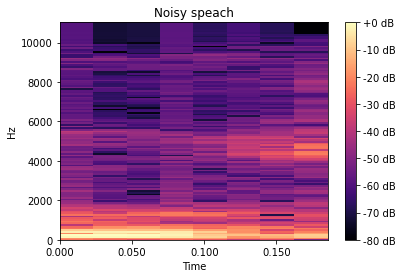

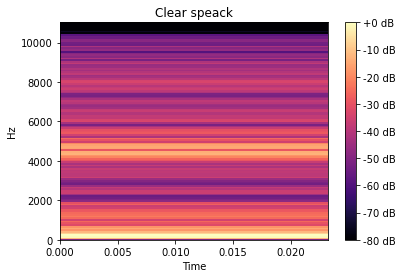

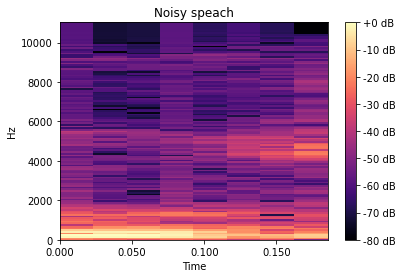

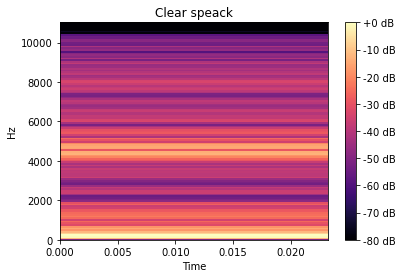

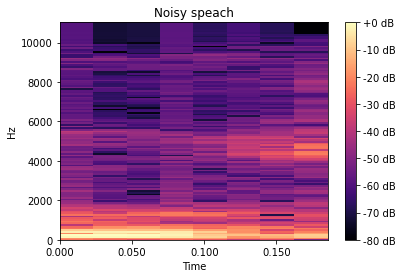

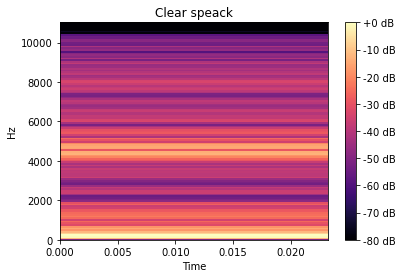

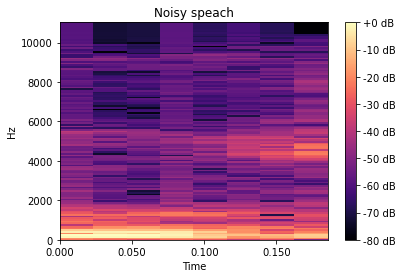

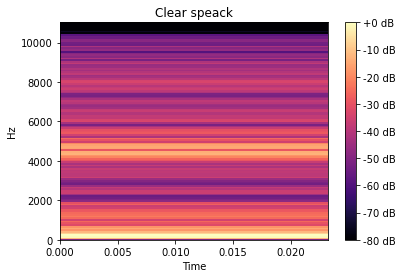

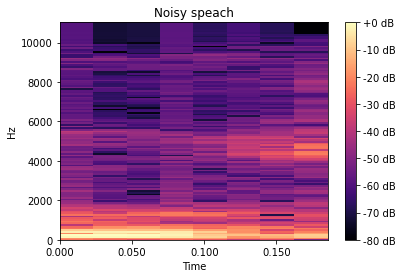

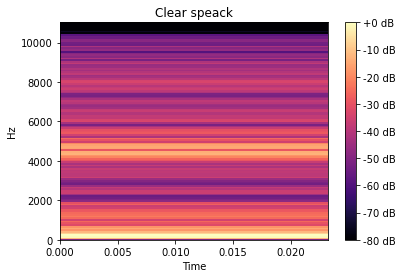

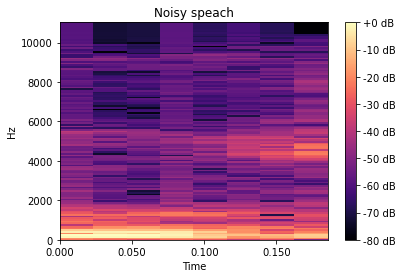

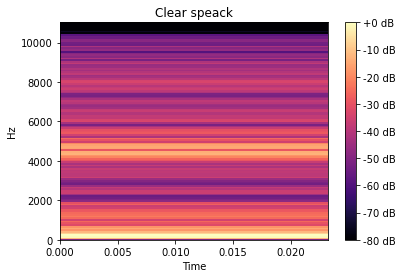

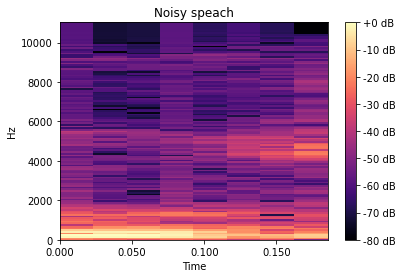

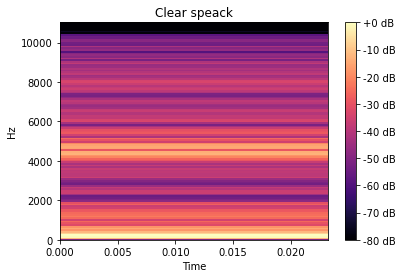

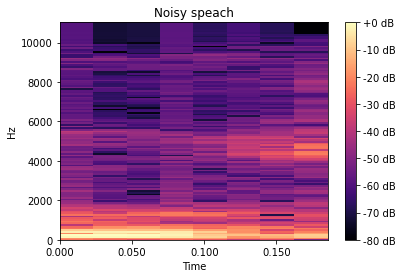

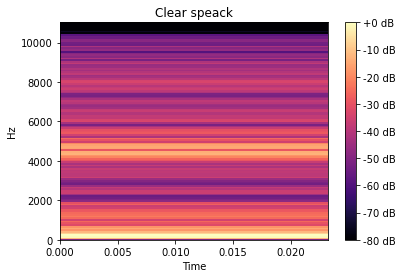

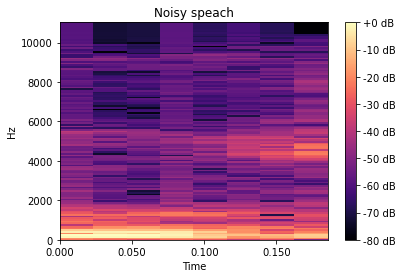

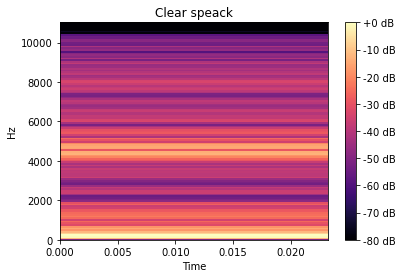

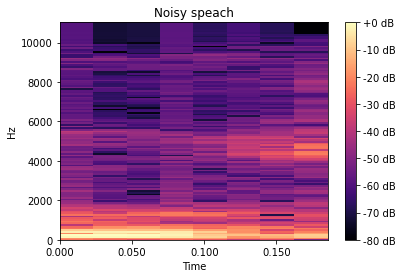

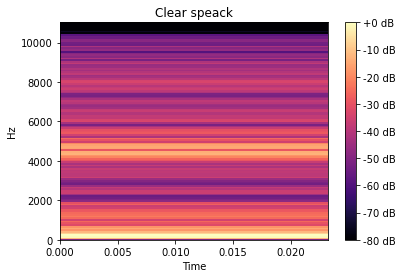

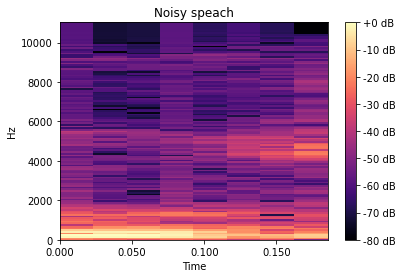

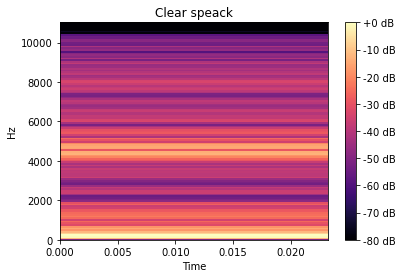

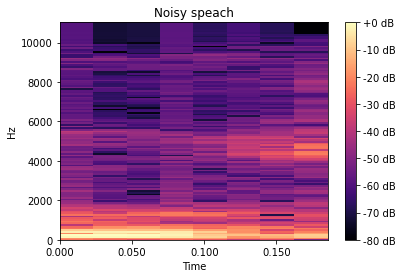

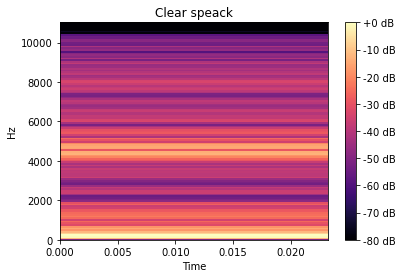

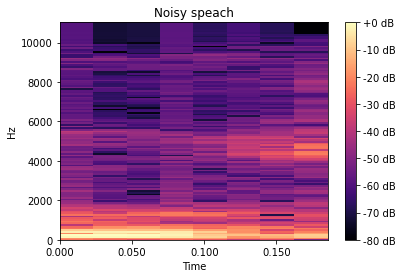

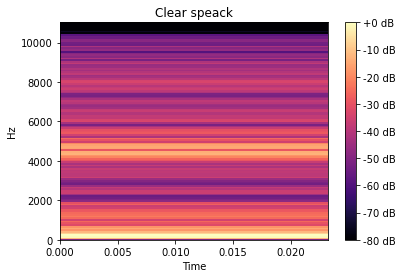

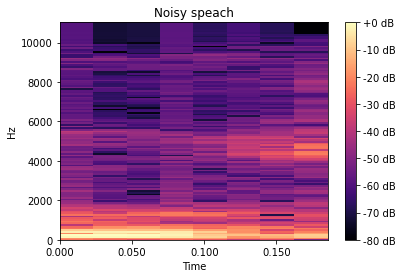

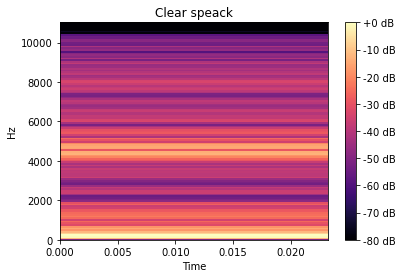

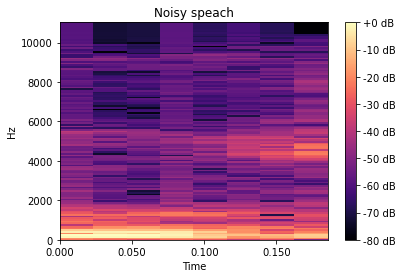

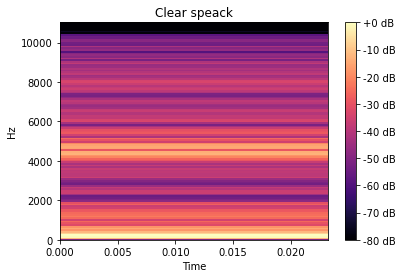

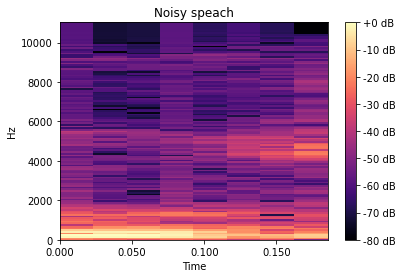

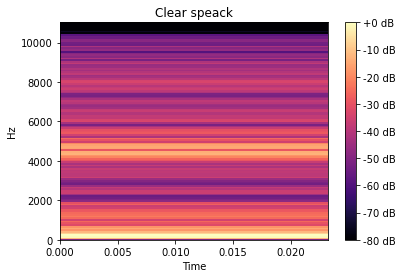

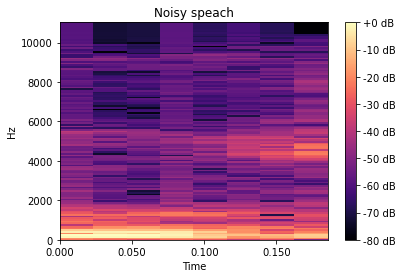

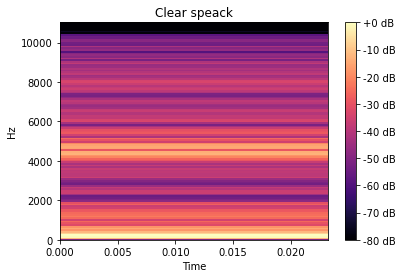

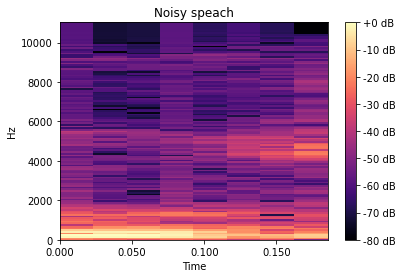

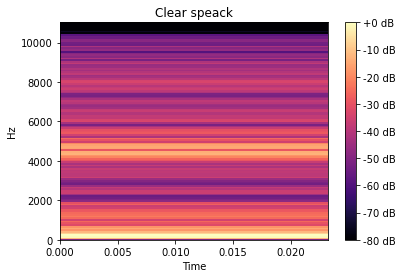

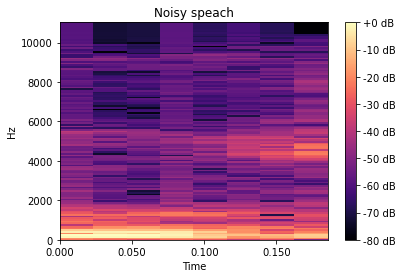

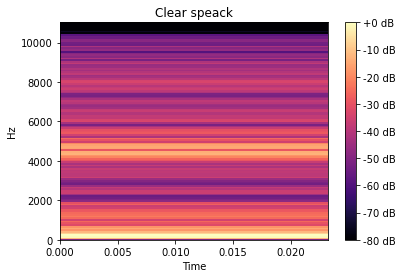

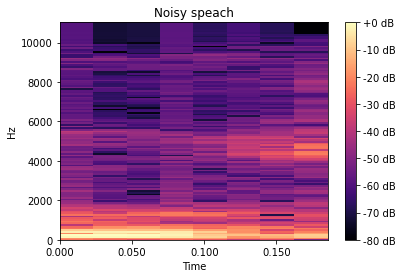

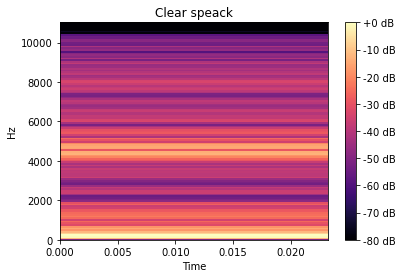

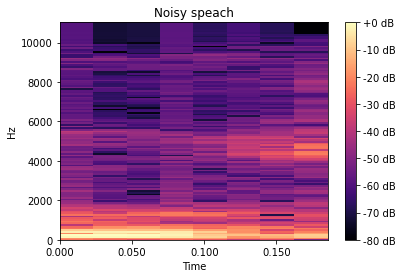

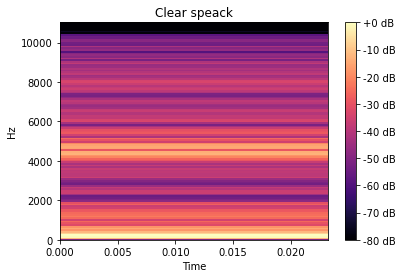

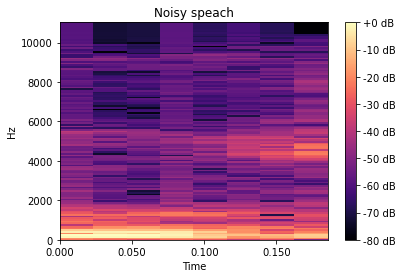

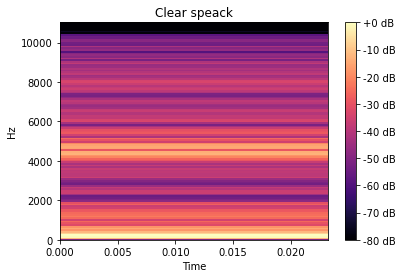

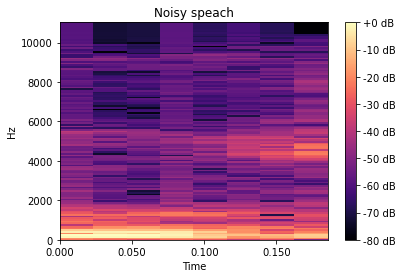

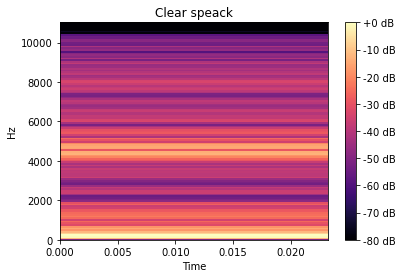

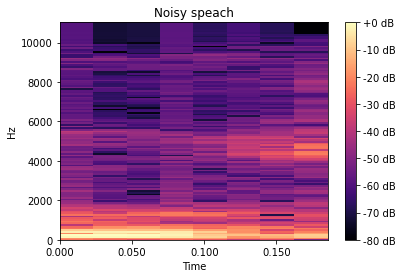

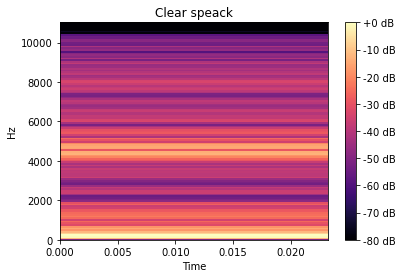

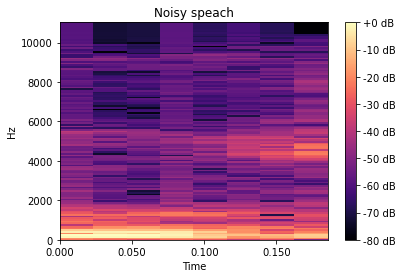

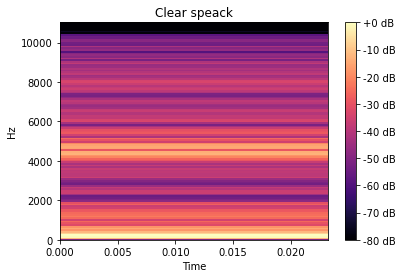

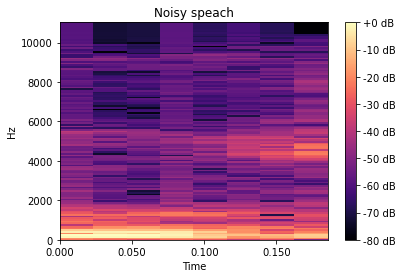

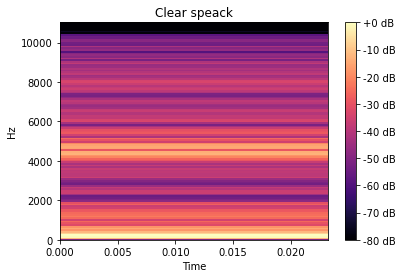

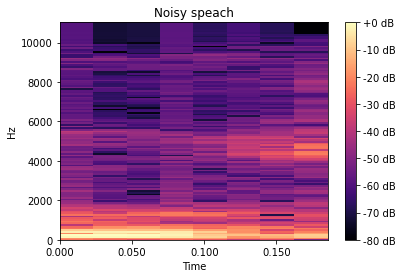

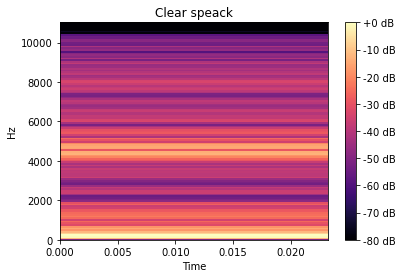

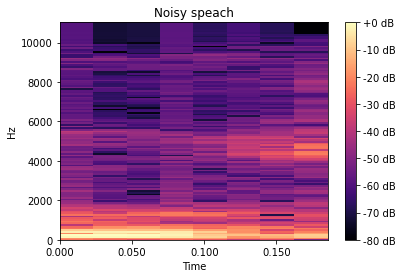

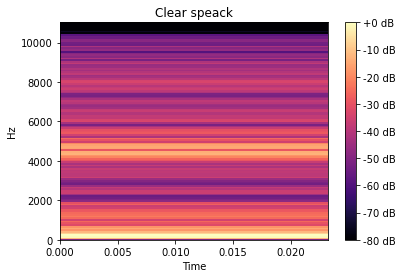

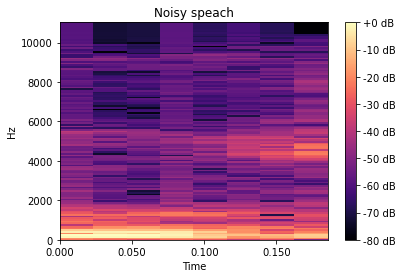

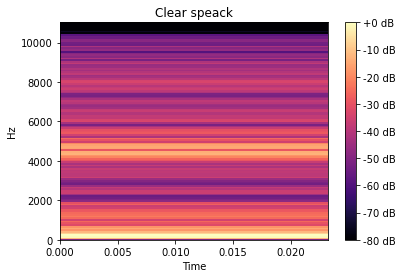

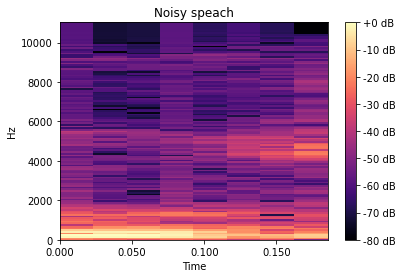

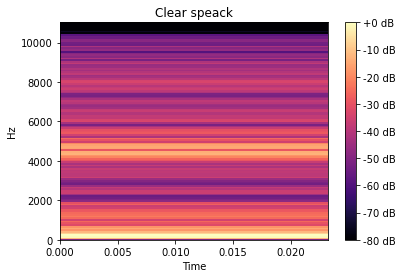

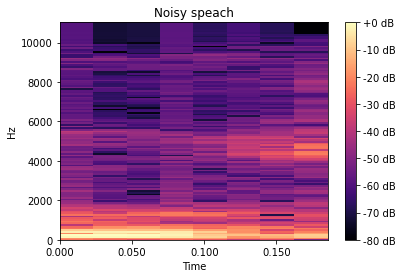

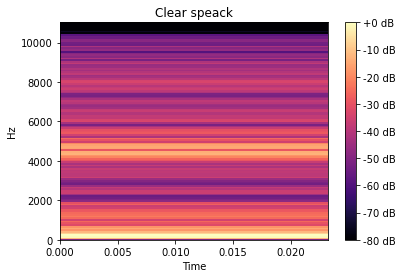

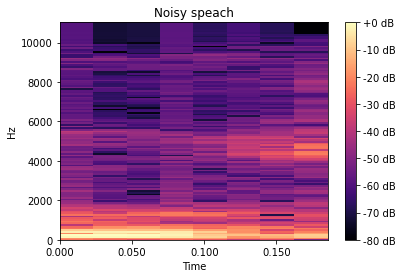

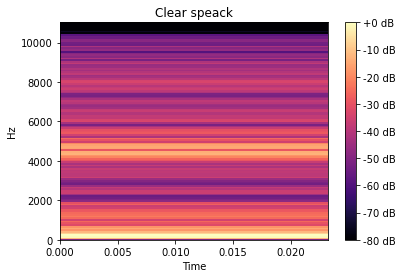

In [20]:

for xb,yb in train_loader:
    
    for i in range(len(xb)):
        noise_and_speach_stft_abs_db = librosa.amplitude_to_db(xb[1],ref=np.max)
        fig, ax = plt.subplots()
        img = librosa.display.specshow(noise_and_speach_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
        ax.set_title('Noisy speach')
        fig.colorbar(img, ax=ax, format="%+2.0f dB")

        noise_and_speach_stft_abs_db = librosa.amplitude_to_db(yb[1],ref=np.max)
        fig, ax = plt.subplots()
        img = librosa.display.specshow(noise_and_speach_stft_abs_db, y_axis='linear', x_axis='time', ax=ax)
        ax.set_title('Clear speack')
        fig.colorbar(img, ax=ax, format="%+2.0f dB")

    break

## Model

## Train

In [17]:
for epoch in range(5):
    print("epoha")
    for xb,yb in train_loader:
        print(xb.shape,yb.shape)

epoha
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129

torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])


torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
torch.Size([32, 129, 8]) torch.Size([32, 129, 1])
